In [57]:
%matplotlib inline
import util
import tissue
import matchedFilter
import numpy as np
import matplotlib.pyplot as plt
import myocyteFigs as mF
import optimizer
import bankDetect as bD
import preprocessing as pp
import cv2
import painter

%load_ext autoreload
%autoreload 2

### This is our original image

In [2]:
#img = util.ReadImg("/net/share/pmke226/DataLocker/cardiac/Sachse/171127_tissue/tissue.tif")
#subsection =

### Setup cases for use
filterTwoSarcomereSize = 25
class empty: pass
case = empty()

case = empty()
case.loc_um = [3594,0]
case.extent_um = [400,400]

tissue.SetupCase(case)

Extracting 399x399 region from 3916x4093 image


### Now we have to preprocess it

- Just using reorient routine to get an idea of major axis angle (don't want to rotate since that adds black space)
- Resize based on previous analysis
- Use CLAHE routine
- Perform intelligent thresholding based off of previous analysis

In [3]:
_,degreesOffCenter = pp.reorient(case.subregion)
imgTwoSarcSize = 22
scale = float(filterTwoSarcomereSize) / float(imgTwoSarcSize)
case.subregion = cv2.resize(case.subregion,None,fx=scale,fy=scale,interpolation=cv2.INTER_CUBIC)
case.subregion = pp.applyCLAHE(case.subregion,filterTwoSarcomereSize)
ceilingValue = 7
floorValue = 0
case.subregion[case.subregion > ceilingValue] = ceilingValue
case.subregion[case.subregion < floorValue] = floorValue
case.subregion -= np.min(case.subregion)
case.subregion = case.subregion.astype(float) / float(np.max(case.subregion))

Reorienting Myocyte
Image is 27.99714736124264 degrees off center
Applying CLAHE to Myocyte


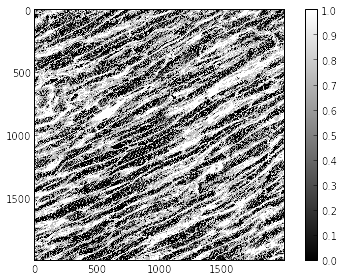

In [56]:
plt.figure()
plt.imshow(case.subregion,cmap='gray')
plt.colorbar()
plt.show()

In [4]:
bigDims = np.asarray(np.shape(case.subregion))
cutOff = -1 * (bigDims - 2000)
print cutOff

[-274 -274]


In [5]:
case.subregion = case.subregion[:cutOff[0],:cutOff[1]]
print np.shape(case.subregion)

(2000, 2000)


In [6]:
img = case.subregion.copy()
dimOrig = np.asarray(np.shape(img))

### Here we create randomized images that are 1/4 of the original size (1/2 in each dimension), which will be comprised of subimages that are 200x200

In [14]:

dimSubImg = np.array([200,200])
subDiv = dimOrig/dimSubImg

# create list of subimages from which we will draw random samples 
subImgs = []
for i in range(subDiv[0]):
    for j in range(subDiv[0]):
      damin=[i*dimSubImg[0]  ,j*dimSubImg[1]]
      damax=[(i+1)*dimSubImg[0], (j+1)*dimSubImg[1]]
      #print damin, damax
      subImg = img[damin[0]:damax[0],damin[1]:damax[1]]  
      subImgs.append(subImg)  

In [15]:
# create a random bootstrap image
dimBootstrap = dimOrig/2

def MakeBootstrap(
  dimBootstrap,
  dimSubImg,
  subImgs,
  verbose=True
):
    subDiv = dimBootstrap/dimSubImg

    nRandomDraws = np.prod(subDiv)
    from random import randint
    randInts = np.asarray( [randint(0,len(subImgs)-1) for p in range(0,nRandomDraws)],dtype=int )
    
    #randomDraws = subImgs[ randInts ]

    ### Changing bootstrapped image to be a list as to not mess with discontinuity along edges
    #bootStrapImg = np.zeros(dimBootstrap)
    bootStrapImg = []
    
    ctr=0
    for i in range(subDiv[0]):
        for j in range(subDiv[1]):
          damin=[i*dimSubImg[0]  ,j*dimSubImg[1]]
          damax=[(i+1)*dimSubImg[0], (j+1)*dimSubImg[1]]
          #print damin, damax
          #subImg = img[damin[0]:damax[0],damin[1]:damax[1]]  
          #print ctr  
          bootStrapImg.append(subImgs[ randInts[ctr] ])
          ctr+=1 
    if verbose:    
      #plt.figure()  
      print randInts   
      #plt.pcolormesh(bootStrapImg,cmap='gray')   
    return bootStrapImg       


print "Example random image" 
bootStrap = MakeBootstrap(dimBootstrap,dimSubImg,subImgs)

Example random image
[41 92 93 69 76 97 57 85 32 19 32 29 52 64 95 50 10 25 52  8 13 47  8  2
 22]


### Do bootstrapping 

In [58]:
%%capture
# ^ turns off print statements for cell

numBootstrapTests = 250
#numBootstrapTests = 2
inputs = empty()
inputs.useGPU = False
iters = [-25,-20,-15,-10,-5,0,5,10,15,20,25] - degreesOffCenter # to account for rotations
ttFilterName = "./myoimages/newSimpleWTFilter.png"
ttPunishmentName = "./myoimages/newSimpleWTPunishmentFilter.png"
ltFilterName = "./myoimages/LongitudinalFilter.png"
lossFilterName = "./myoimages/LossFilter.png"
returnAngles = True

ttFilter = util.LoadFilter(ttFilterName)
ttY,ttX = util.measureFilterDimensions(ttFilter)

dim = 5
kernel = np.ones((dim,dim),dtype=np.float32)
kernel /= np.sum(kernel)
### make longer WT filter so more robust to striation angle deviation
ttFilter = util.LoadFilter(ttFilterName)
longFilter = np.concatenate((ttFilter,ttFilter,ttFilter))
rotInputs = empty()

#print np.shape(np.ones(dimSubImg))
dummyImage = np.stack((np.zeros(dimSubImg),np.zeros(dimSubImg),np.zeros(dimSubImg)),axis=2).astype(np.uint8)
print np.shape(dummyImage)


def yourStatistic(data):
    data[data != 0] = 1.
    return np.mean(data)

def angleStatistic(data):
    '''
    Takes the marked angles from the analysis and reports back what percentage of the angles lie within
    5 degrees of the major axis
    '''
    hitCounts = 0
    totalHits = np.count_nonzero(np.where(data != -1))
    rots = [4,5,6] # indexes of iters which we care about
    for i in rots:
        hitCounts += np.count_nonzero(np.where(data == i))
    return float(hitCounts) / float(totalHits)
    

yourStatistics=np.zeros(numBootstrapTests)
WTmeans = []
#LTmeans = []; Lossmeans = []; 
angleStats = []
for i in range(numBootstrapTests):
    bootStrap = MakeBootstrap(dimBootstrap,dimSubImg,subImgs,verbose=False)
    # put in your mf tool
    #yourStatistics[i]=#yourStatistic(bootStrap)
    smallWTStats = []
    smallAngleStats = []
    for smallImg in bootStrap:
        # store image in inputs class
        inputs.imgOrig = smallImg
        
        ### do filtering for content
        WTresults = mF.WT_Filtering(inputs,iters,ttFilterName,ltFilterName,None,None,returnAngles)
        #LTresults = mF.LT_Filtering(inputs,iters,ltFilterName,None,False)
        #Lossresults = mF.Loss_Filtering(inputs,lossFilterName,None,False)
        
        # now paste unit cells onto image to get idea of what marked myocyte would look like
        #resultImage = mF.markPastedFilters(Lossresults.stackedHits,
        #                                   LTresults.stackedHits,
        #                                   WTresults.stackedHits,
        #                                   dummyImage.copy())
        
        # paste until cells onto image to get accurate representation of WT structure
        WT_hits = painter.doLabel(WTresults,dx=ttX,dy=ttY,thresh=0)
        #plt.figure()
        #plt.imshow(WT_hits)
        #plt.colorbar()
        #plt.show()
        
        #WT_hits_count = np.count_nonzero(WT_hits)
        
        ### do angle analysis
        smoothed = matchedFilter.matchedFilter(inputs.imgOrig,kernel,demean=False)
        rotInputs.imgOrig = smoothed
        rotInputs.mfOrig = longFilter

        params = optimizer.ParamDict(typeDict='WT')
        params['snrThresh'] = 0 # to pull out max hit
        params['filterMode'] = 'simple' # we want no punishment since that causes high variation

        # perform simple filtering
        smoothedWTresults = bD.DetectFilter(rotInputs,params,iters,returnAngles=returnAngles)
        smoothedHits = smoothedWTresults.stackedAngles
        
        # pull out actual hits from smoothed results
        smoothedHits[WTresults.stackedHits == 0] = -1
        stackedAngles = smoothedHits
        #dims = np.shape(stackedAngles)
        #angleCounts = []
        #for i in range(dims[0]):
        #  for j in range(dims[1]):
        #    rotArg = stackedAngles[i,j]
        #    if rotArg != -1:
        #      ### indicates this is a hit
        #      angleCounts.append(iters[rotArg])
        angleCounts = angleStatistic(stackedAngles)


        ### do statistics now
        smallWTStats.append(yourStatistic(WT_hits))
        #LTmeans.append(yourStatistic(LTresults.stackedHits))
        #Lossmeans.append(yourStatistic(Lossresults.stackedHits))
        smallAngleStats.append(angleCounts)
    WTmeans.append(np.mean(smallWTStats))
    angleStats.append(np.mean(smallAngleStats))
        




In [59]:
#print "Bootstrap mean: %f" % (np.mean(yourStatistics))
#print "Bootstrap stddev: %f" % (np.std(yourStatistics))
#print "Bootstrap stderr: %f" % (np.std(yourStatistics)/np.sqrt(numBootstrapTests))
#print WTmeans
print np.mean(WTmeans)
print np.std(WTmeans)

#print angleStats
print np.mean(angleStats)
print np.std(angleStats)

0.21354396399999998
0.008469383006258721
0.31021970509482527
0.017033666792550604


In [63]:
print "Mean WT Detection Rate:",str(np.mean(WTmeans)*100)[:5],'+-',str(np.std(WTmeans)*100)[:5]+'%'
#print "Std Dev of WT Detection Rate:",+'%'
print "Percent WT Detection Within 5 Degree of Minor Axis:",str(np.mean(angleStats)*100)[:5],'+-',str(np.std(angleStats)*100)[:5]+'%'
#print "Std Dev of Angle of WT Detection:",+'%'

Mean WT Detection Rate: 21.35 +- 0.846%
Percent WT Detection Within 5 Degree of Minor Axis: 31.02 +- 1.703%
